In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import json
from sklearn.cluster import AgglomerativeClustering
import spacy
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in data
data_raw = pd.DataFrame(json.load(open("ecfs_17-108_0.json")))
text = pd.DataFrame()

In [3]:
%%time
#drop rows with NaN in the comments
rows_to_drop = list()
for ii in range(3,len(data_raw["text_data"])):
    if pd.isnull(data_raw["text_data"][ii]) == True:
        if pd.isnull(data_raw["text_data_docs"][ii][0]) == True:
            rows_to_drop.append(ii)
            
data = data_raw.drop(rows_to_drop)

CPU times: user 327 ms, sys: 3.95 ms, total: 331 ms
Wall time: 333 ms


In [4]:
#get text of comments
text_list = list()
for ii in range(3,len(data["text_data"])):
        if pd.isnull(data["text_data"][ii]) == False:
            text_list.append(data["text_data"][ii])
        elif pd.isnull(data["text_data_docs"][ii][0]) == False:
            if type(data["text_data_docs"][ii][0]) == dict:
                text_list.append(data["text_data_docs"][ii][0]["data"])
            else:
                text_list.append(data["text_data_docs"][ii][0])
        else:
            continue

In [5]:
%%time
#vectorize text
nlp = spacy.load("en")

text_vec = list()

for comm in text_list:
    if type(comm) == str:
        comm_broken_down = nlp(comm)
        comm_vec = np.mean([word.vector for word in comm_broken_down], axis=0)
        text_vec.append(comm_vec)
    else:
        text_vec.append(np.zeros(len(comm_vec)))        

CPU times: user 55min 42s, sys: 1min 10s, total: 56min 52s
Wall time: 29min 8s


In [6]:
text = pd.DataFrame()
conf_num = data["confirmation_number"][3:].tolist()
text["confirmation_number"] = conf_num
text["text_data"] = text_list

In [9]:
%%time
#create appropriate clusterer
sil_avg = list()

num_clusters = [30,40,50,60,70,80,90,100]
for num in num_clusters:
    clusterer = AgglomerativeClustering(n_clusters=num, linkage='ward')
    labels = clusterer.fit_predict(text_vec)
    text["cluster_id"] = labels
    text = pd.concat([text["cluster_id"],text["confirmation_number"],
                  text["text_data"],pd.DataFrame(text_vec)],axis=1)
    features = text.iloc[:,-300:]
    #get average silhouette score to determine whether number of clusters was appropriate
    silhouette_avg = silhouette_score(features,labels)
    sil_avg.append(silhouette_avg)

CPU times: user 9min 1s, sys: 25.8 s, total: 9min 26s
Wall time: 9min 8s


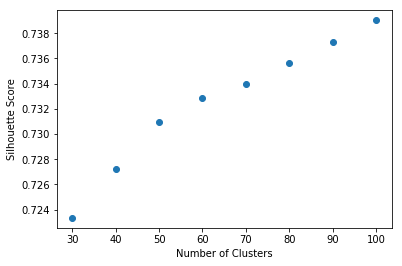

In [10]:
plt.plot(num_clusters,sil_avg,'o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score");

The silhouette score isn't greatly impacted by the number of clusters chosen after num = 50. Similar comments could be broken down into many clusters so it isn't advantageous to choose too many clusters while trying to identify the context of comments.

In [11]:
%%time
num=50
#cluster text vectors and generate silhouette scores
clusterer = AgglomerativeClustering(n_clusters=num, linkage='ward')
labels = clusterer.fit_predict(text_vec)

text["cluster_id"] = labels
text = pd.concat([text["cluster_id"],text["confirmation_number"],
                  text["text_data"],pd.DataFrame(text_vec)],axis=1)

CPU times: user 1min 10s, sys: 2.75 s, total: 1min 12s
Wall time: 1min 13s


In [15]:
text.to_csv("fcc_comments_clustered.csv")

In [122]:
%%time
#plot clusters using silhouette scores
features = text.iloc[:,-300:]
silhouette_samp_scores = silhouette_samples(features,text["cluster_id"])

CPU times: user 14.8 s, sys: 1.26 s, total: 16 s
Wall time: 13.7 s


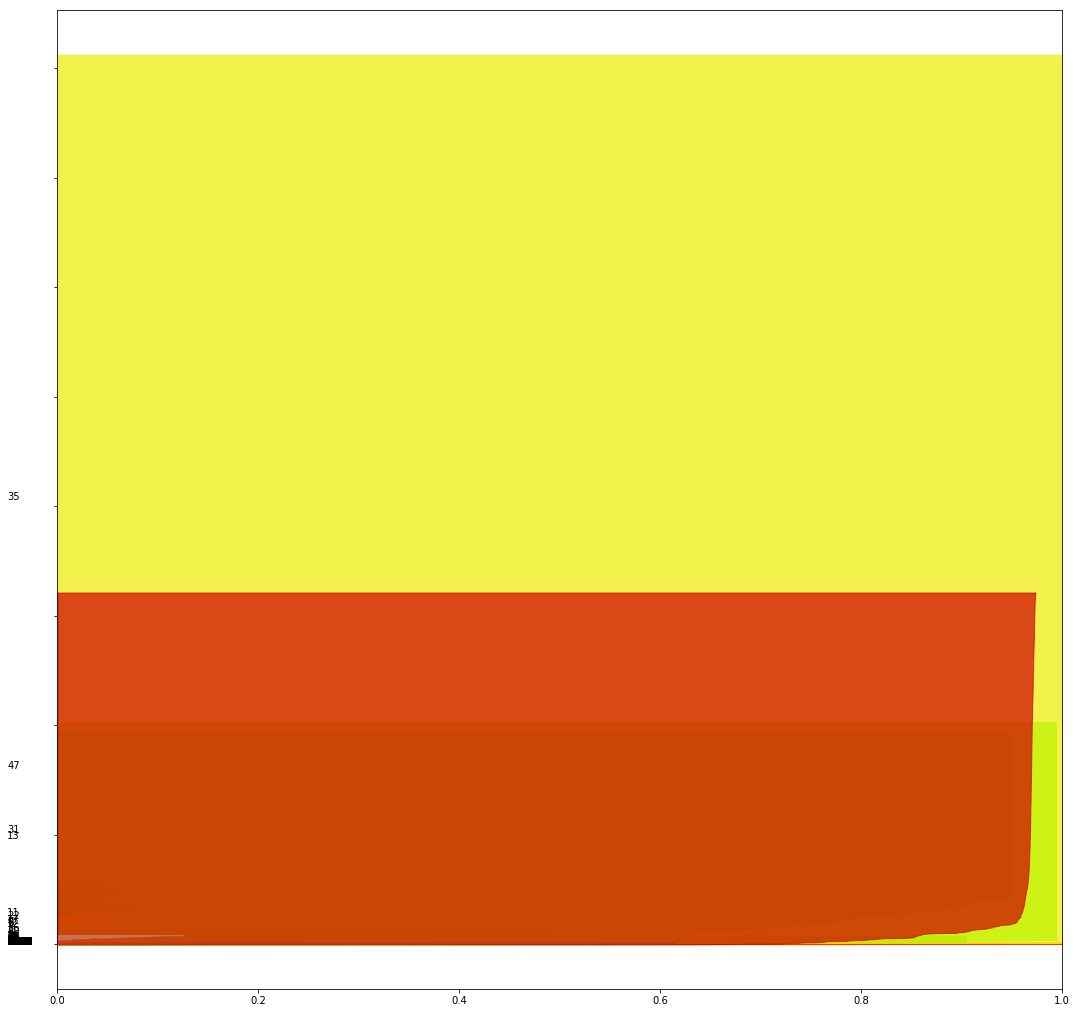

In [136]:
num_clusters_skipped = 0 # speed up by skipping the first few (huge) clusters; 
mask = list(range(num_clusters_skipped, text['cluster_id'].max() + 1)) 
#since count = max + 1; ignore outliers (-1)

fig2, ax2 = plt.subplots(1, 1)
fig2.set_size_inches(18, 18)

ax2.set_xlim([0.0, 1.0])
ax2.set_yticklabels([''*len(labels)])

for ii in range(len(text["cluster_id"])):
    cluster_scores = silhouette_samp_scores[text["cluster_id"]==ii]
    cluster_scores.sort()
    upper_lim = cluster_scores.shape[0]
    color = cm.spectral(float(ii) / num)
    ax2.fill_betweenx(np.arange(0, upper_lim),0, cluster_scores,facecolor=color, edgecolor=color, alpha=0.7)
    ax2.text(-0.05, 0.5 * upper_lim, str(ii))


    